In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import gseapy as gp
import statsmodels.api as sm
from adjustText import adjust_text

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# scDRS tools
import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Set file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
DF_HOM = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
DIC_MAP_H2M = {x:y for x,y in zip(DF_HOM['HUMAN_GENE_SYM'], DF_HOM['MOUSE_GENE_SYM'])}
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}
DF_GS = pd.read_csv(DATA_PATH+'/gs_file/magma_10kb_top1000_zscore.74_traits.rv1.gs', sep='\t', index_col=0)
DF_TRAIT_INFO = pd.read_csv(DATA_PATH+'/supp_table.rv1/trait_info.tsv', sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_tcell.rv1'

# Set data info
DS_LIST = ['canogamez', 'nathan']
DIC_INFO = {}
DIC_INFO['tms_facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
DIC_INFO['tms_droplet'] = {'species': 'mmusculus', 'dname': 'TMS droplet'}
DIC_INFO['ts_facs'] = {'species': 'hsapiens', 'dname': 'TS FACS'}
DIC_INFO['canogamez'] = {'species': 'hsapiens', 'dname': 'Cano-Gamez & Soskic et al.'}
DIC_INFO['nathan'] = {'species': 'hsapiens', 'dname': 'Nathan et al.'}

# Set score file
DIC_SCORE_PATH = {
    'canogamez' : DATA_PATH+'/score_file/score.canogamez_with_cov.magma_10kb_top1000_zscore',
    'nathan' : DATA_PATH+'/score_file/score.nathan_ni_2021_with_cov.magma_10kb_top1000_zscore',
                 }

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['canogamez'] = [
    'PASS_IBD_deLange2017', 
    'PASS_CD_deLange2017',
    'PASS_UC_deLange2017', 
    'PASS_Rheumatoid_Arthritis', 
    'PASS_Multiple_sclerosis', 
    'UKB_460K.disease_AID_ALL', 
    'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
    'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED',
    'UKB_460K.disease_ASTHMA_DIAGNOSED', 
    'UKB_460K.disease_RESPIRATORY_ENT',
    'UKB_460K.body_HEIGHTz',
]
DIC_TRAIT_LIST['nathan'] = DIC_TRAIT_LIST['canogamez'].copy()

### Load data 

In [ ]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['canogamez'] = dl.load_canogamez(DATA_PATH)
dic_data_raw['canogamez'].obs['cell_ontology_class'] = dic_data_raw['canogamez'].obs['cluster.id'].copy()
dic_data_raw['nathan'] = dl.load_nathan(DATA_PATH)
dic_data_raw['nathan'].obs['cell_ontology_class'] = dic_data_raw['nathan'].obs['cluster_name'].copy()

In [ ]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
dic_cell_batch = {x:{} for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = DIC_SCORE_PATH[score]+'/%s.score.gz'%trait
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

In [ ]:
# Load control score 
dic_ctrl_score = {}
for score in DIC_SCORE_PATH:
    if score.endswith('.ref'):
        print('Skip %s'%score)
        continue
    dic_ctrl_score[score] = {}
    for trait in DIC_TRAIT_LIST[score]:
        file_path = DIC_SCORE_PATH[score]+'/%s.full_score.gz'%trait
        if os.path.exists(file_path):
            print('# Loading %s %s'%(score, trait))
            dic_ctrl_score[score][trait] = pd.read_csv(file_path, sep='\t', index_col=0)
        else:
            print('# missing: %s'%file_path)

In [6]:
# # Check consistency
# for score in dic_ctrl_score:
#     cell_list = sorted(set(dic_score[score].index) & set(dic_score[score+'.ref'].index))
#     for trait in dic_ctrl_score[score]:
        
#         print('|{:^10s}|{:^30s}|{:^12s}|{:^30s}|{:^20s}|'.format(
#             score, trait, 
#             'PCC=%0.3f'%np.corrcoef(dic_score[score+'.ref'].loc[cell_list, '%s.norm_score'%trait], 
#                                     dic_score[score].loc[cell_list, '%s.norm_score'%trait])[0,1],
#             'n_cell %d/%d/%d'%
#             (dic_score[score].shape[0], dic_score[score+'.ref'].shape[0], len(cell_list)),
#             'n_sig  %d/%d'%((dic_score[score]['%s.fdr'%trait]<0.2).sum(), 
#                             (dic_score[score+'.ref']['%s.fdr'%trait]<0.2).sum())
#         ))

|canogamez |     PASS_IBD_deLange2017     | PCC=0.963  |   n_cell 43112/43112/43112   |   n_sig  342/252   |
|canogamez |     PASS_CD_deLange2017      | PCC=0.962  |   n_cell 43112/43112/43112   |   n_sig  276/186   |
|canogamez |     PASS_UC_deLange2017      | PCC=0.965  |   n_cell 43112/43112/43112   |   n_sig  224/221   |
|canogamez |  PASS_Rheumatoid_Arthritis   | PCC=0.954  |   n_cell 43112/43112/43112   |    n_sig  16/3     |
|canogamez |   PASS_Multiple_sclerosis    | PCC=0.957  |   n_cell 43112/43112/43112   |     n_sig  1/0     |
|canogamez |   UKB_460K.disease_AID_ALL   | PCC=0.953  |   n_cell 43112/43112/43112   |    n_sig  55/35    |
|canogamez |UKB_460K.disease_HYPOTHYROIDISM_SELF_REP| PCC=0.966  |   n_cell 43112/43112/43112   |   n_sig  101/56    |
|canogamez |UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED| PCC=0.971  |   n_cell 43112/43112/43112   |   n_sig  374/262   |
|canogamez |UKB_460K.disease_ASTHMA_DIAGNOSED| PCC=0.951  |   n_cell 43112/43112/43112   |    n_sig  125/1 

### Cell-type trait association 

In [8]:
# Compute association statistics 
dic_stats = {}
for ds in DS_LIST:
    print(ds)
    score = ds
    celltype_list = sorted(set(dic_data_raw[ds].obs['cell_ontology_class']))
    trait_list = DIC_TRAIT_LIST[ds]
    dic_stats[ds] = pd.DataFrame(index=celltype_list, columns=trait_list, dtype=float)
    for trait in trait_list:
        for ct in celltype_list:
            cell_list = dic_data_raw[ds].obs_names[dic_data_raw[ds].obs['cell_ontology_class']==ct]
            score_q95 = np.quantile(dic_score[score].loc[cell_list, '%s.norm_score'%trait], 0.95)
            temp_df = dic_ctrl_score[score][trait].loc[cell_list].copy()
            temp_df = temp_df[[x for x in temp_df.columns if x.startswith('ctrl_norm_score')]]
            v_ctrl_score_q95 = np.quantile(temp_df, 0.95, axis=0)
            dic_stats[ds].loc[ct,trait] = ((v_ctrl_score_q95>=score_q95).sum()+1) / (v_ctrl_score_q95.shape[0]+1)

canogamez
nathan


In [44]:
# Contrast between traits
trait_list = [
    'PASS_IBD_deLange2017', 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP', 'UKB_460K.disease_RESPIRATORY_ENT'
]

for ds in DS_LIST:
#     ind_select = (dic_stats[ds][trait_list]<0.01).sum(axis=1)>0
    ind_select = (dic_stats[ds]<0.01).sum(axis=1)>0
    print(ds)
    display(dic_stats[ds].loc[ind_select, trait_list])
    print('')
#     break

canogamez


,PASS_IBD_deLange2017,UKB_460K.disease_HYPOTHYROIDISM_SELF_REP,UKB_460K.disease_RESPIRATORY_ENT
TCM1 (Th17/iTreg),0.017982,0.056943,0.572428
TEM (Th17/iTreg),0.001998,0.000999,0.145854
TN (Th17/iTreg),0.000999,0.003996,0.000999
nTreg (Th0),0.001998,0.000999,0.024975



nathan


,PASS_IBD_deLange2017,UKB_460K.disease_HYPOTHYROIDISM_SELF_REP,UKB_460K.disease_RESPIRATORY_ENT
CD4+ CD161+ Th2,0.021978,0.258741,0.011988
CD4+ RORC+ Treg,0.010989,0.000999,0.000999
CD4+ Th17,0.041958,0.025974,0.006993
CD4+ Th17/1,0.022977,0.202797,0.002997
CD4+ Th2,0.052947,0.225774,0.029970
CD4+ Treg,0.409590,0.000999,0.167832
CD4+ activated,0.022977,0.014985,0.005994
CD4+ lncRNA,0.111888,0.043956,0.004995


In [63]:
ind_select = dic_data_raw['canogamez'].obs['cell_ontology_class']=='TN (Th17/iTreg)'
temp_df = dic_data_raw['canogamez'].obs.loc[ind_select]\
    .groupby(['cell.type', 'cytokine.condition', 'cell_ontology_class']).agg({'donor.id':len})
temp_df.loc[temp_df['donor.id']>0]

donor.id
cell.type cytokine.condition cell_ontology_class          
Memory    Th0                TN (Th17/iTreg)          79.0
          Th2                TN (Th17/iTreg)          21.0
          Th17               TN (Th17/iTreg)         112.0
          iTreg              TN (Th17/iTreg)         191.0
Naive     Th0                TN (Th17/iTreg)         136.0
          Th2                TN (Th17/iTreg)         148.0
          Th17               TN (Th17/iTreg)         826.0
          iTreg              TN (Th17/iTreg)        1105.0

In [59]:
dic_data_raw['canogamez'].obs

,cell.type,cytokine.condition,donor.id,batch.10X,nGene,nUMI,percent.mito,S.Score,G2M.Score,Phase,cluster.id,effectorness,n_counts,cell_ontology_class
N_resting_AAACCTGAGCTGTCTA,Naive,UNS,D4,2,1163,4172,0.023496,-0.134199,-0.159211,G1,TN (resting),0.151812,4171.0,TN (resting)
N_resting_AAACCTGTCACCACCT,Naive,UNS,D4,2,1037,3690,0.020867,-0.101756,-0.203707,G1,TN (resting),0.031763,3690.0,TN (resting)
N_resting_AAACCTGTCCGTTGTC,Naive,UNS,D2,2,1245,4446,0.027903,-0.145131,-0.164210,G1,TN (resting),0.113897,4444.0,TN (resting)
N_resting_AAACGGGAGGGTTCCC,Naive,UNS,D4,2,1016,3913,0.011509,-0.069492,-0.190810,G1,TN (resting),0.341240,3910.0,TN (resting)
N_resting_AAACGGGCAACAACCT,Naive,UNS,D1,2,1005,3557,0.039640,-0.124007,-0.143379,G1,TN (resting),0.019741,3557.0,TN (resting)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M_iTreg_r2_TTTGCGCGTGATAAGT,Memory,iTreg,D2,2,3491,14063,0.047003,-0.171570,-0.250832,G1,TEM (Th17/iTreg),0.894785,14063.0,TEM (Th17/iTreg)
M_iTreg_r2_TTTGGTTCATGATCCA,Memory,iTreg,D3,2,4525,17509,0.040734,-0.090219,-0.263634,G1,TEM (Th17/iTreg),0.443469,17504.0,TEM (Th17/iTreg)
M_iTreg_r2_TTTGGTTTCCTGTACC,Memory,iTreg,D1,2,3381,16735,0.022172,0.121549,-0.133797,S,TEM (Th17/iTreg),0.380790,16733.0,TEM (Th17/iTreg)
M_iTreg_r2_TTTGGTTTCGGCTTGG,Memory,iTreg,D3,2,3690,16720,0.036787,-0.180000,-0.279017,G1,TEM (Th17/iTreg),0.758033,16718.0,TEM (Th17/iTreg)


canogamez TEM (Th17/iTreg)


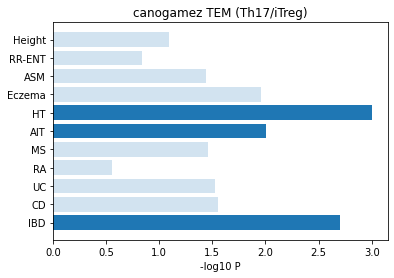

canogamez TN (Th17/iTreg)


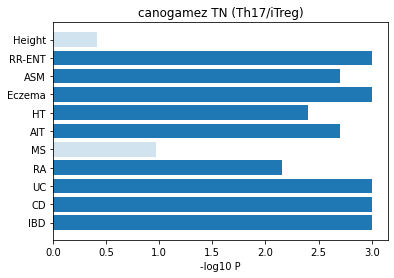

canogamez nTreg (Th0)


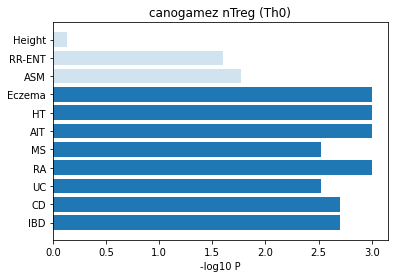

nathan CD4+ RORC+ Treg


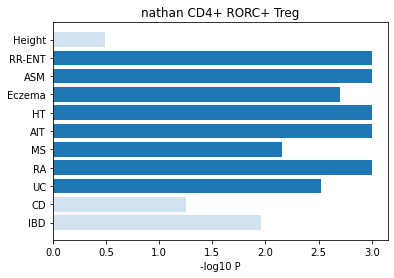

nathan CD4+ Th17


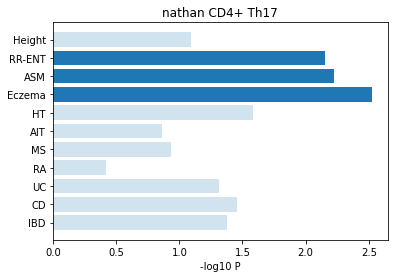

nathan CD4+ Th17/1


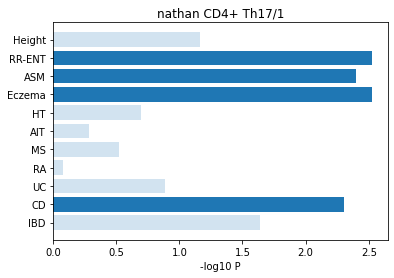

nathan CD4+ Th2


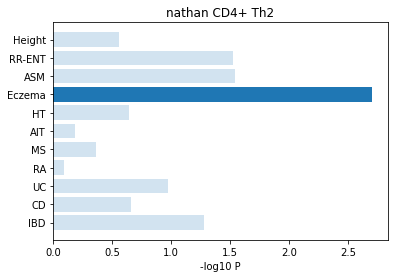

nathan CD4+ Treg


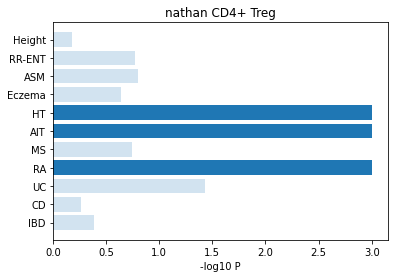

nathan CD4+ lncRNA


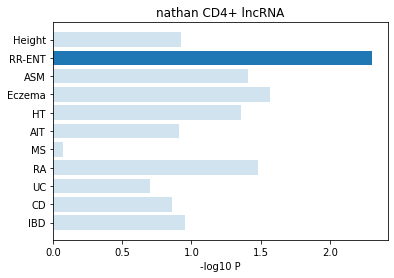

In [58]:
for ds in DS_LIST:
    ind_select = (dic_stats[ds]<0.005).sum(axis=1)>0
    for ct in dic_stats[ds].index[ind_select]:
        print(ds, ct)
        plt.figure()
        ind_select = dic_stats[ds].loc[ct]<0.01
        plt.barh(np.arange(dic_stats[ds].shape[1])[ind_select], -np.log10(dic_stats[ds].loc[ct, ind_select]))
        plt.barh(np.arange(dic_stats[ds].shape[1])[~ind_select], -np.log10(dic_stats[ds].loc[ct, ~ind_select]),
                 color='C0', alpha=0.2)
        plt.yticks(np.arange(dic_stats[ds].shape[1]), [DF_TRAIT_INFO.loc[x, 'Code'] for x in dic_stats[ds]])
        plt.xlabel('-log10 P')
        plt.title('%s %s'%(ds, ct))
        plt.show()

In [50]:
DF_TRAIT_INFO

,Trait Name,Trait_Identifier,Code,Category,Reference,N,M,h2g,sd,Z,Intercept,log10 Me Common
Trait_Identifier,,,,,,,,,,,,
PASS_CD_deLange2017,Crohn's Disease,PASS_CD_deLange2017,CD,blood/immune,de Lange et al. 2017 Nat Genet,40266,1150097,0.4152,0.0361,11.501385,1.1010,NaN
PASS_Celiac,Celiac Disease,PASS_Celiac,Celiac,blood/immune,"Dubois et al., 2010 Nat Genet",15283,245449,0.3296,0.0697,4.728838,1.0528,NaN
PASS_IBD_deLange2017,Inflammatory Bowel Disease,PASS_IBD_deLange2017,IBD,blood/immune,de Lange et al. 2017 Nat Genet,59957,1150510,0.3206,0.0243,13.193416,1.1216,3.60 (0.04)
PASS_Lupus,Systemic Lupus Erythematosus,PASS_Lupus,SLE,blood/immune,"Bentham et al., 2015 Nat Genet",14267,654940,0.4584,0.0957,4.789969,1.0899,NaN
PASS_Multiple_sclerosis,Multiple Sclerosis,PASS_Multiple_sclerosis,MS,blood/immune,"IMS Genetics Consortium, 2011 Nature",27148,227549,0.0812,0.0373,2.176944,1.0416,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
UKB_460K.lung_FEV1FVCzSMOKE,FEV1-FVC Ratio,UKB_460K.lung_FEV1FVCzSMOKE,FEV1/FVC,other,UK Biobank,371949,1187057,0.2763,0.0117,23.615385,1.1129,3.38 (0.05)
UKB_460K.lung_FVCzSMOKE,Forced Vital Capacity (FVC),UKB_460K.lung_FVCzSMOKE,FVC,other,UK Biobank,371949,1187057,0.2336,0.0072,32.444444,1.1046,NaN
UKB_460K.pigment_HAIR,Hair Color,UKB_460K.pigment_HAIR,Hair color,other,UK Biobank,452720,1187057,0.1658,0.0211,7.857820,1.2280,NaN


In [9]:
def assign_str(x):
    if x<0.01:
        return '$<$.01'
    elif x<=0.05:
        return ('%0.2f'%x)[1:]
    else:
        return 'ns'

In [39]:
ind_select = dic_data_raw['canogamez'].obs['cluster.id'].isin([
#     'TEM (Th17/iTreg)', 'TN (Th17/iTreg)', 'nTreg (Th0)',
    'TCM1 (Th17/iTreg)',
])
temp_df = dic_data_raw['canogamez'].obs.loc[ind_select].\
    groupby(['cell.type', 'cytokine.condition', 'cluster.id']).agg({'donor.id':len})
display(temp_df.loc[temp_df['donor.id']>100])

donor.id
cell.type cytokine.condition cluster.id                 
Memory    Th17               TCM1 (Th17/iTreg)     414.0
          iTreg              TCM1 (Th17/iTreg)     423.0

In [10]:
# Results in Cano-Gamez & Soskic et al.
ds = 'canogamez'
col = dic_data_raw[ds].obs.columns[0]
temp_df = dic_data_raw[ds].obs.groupby(['cell_ontology_class']).agg({col:len})
display(temp_df)
celltype_list = sorted(temp_df.index)
print('n_celltype=%d'%len(celltype_list), ', '.join(celltype_list))

# Get p-values
df_stats = dic_stats[ds].loc[celltype_list].copy()

# Multiple testing: applied to each trait across cell types
df_stats_fdr = df_stats.copy()
for col in df_stats_fdr:
    df_stats_fdr[col] = multipletests(df_stats_fdr[col], method='fdr_bh')[1]

# Make table 
df_res = df_stats_fdr.loc[(df_stats_fdr<0.05).sum(axis=1)>0].copy()
df_res.columns = [DF_TRAIT_INFO.loc[x, 'Code'] for x in df_res.columns]
for col in df_res:
    df_res[col] = [assign_str(x) for x in df_res[col]]
df_res.index.name = DIC_INFO[ds]['dname']
print(df_res.to_latex(index_names=True, escape=False))

,cell.type
cell_ontology_class,
HSP.high,1174
IFN.high,1318
Mitotic,1650
TCM1 (Th0),1909
TCM1 (Th17/iTreg),1041
TCM2 (Th0),2596
TCM2 (Th17/iTreg),3860
TCM (resting),1915
TEM (Th0),1297


n_celltype=22 HSP.high, IFN.high, Mitotic, TCM (resting), TCM1 (Th0), TCM1 (Th17/iTreg), TCM2 (Th0), TCM2 (Th17/iTreg), TEM (Th0), TEM (Th17/iTreg), TEM (resting), TEMRA (Th0), TEMRA (Th17/iTreg), TEMRA (resting), TN (Th0), TN (Th17), TN (Th17/iTreg), TN (Th2), TN (iTreg), TN (resting), nTreg (Th0), nTreg (resting)
\begin{tabular}{llllllllllll}
\toprule
{} &  IBD &   CD &   UC &   RA &  MS &  AIT &   HT & Eczema &  ASM & RR-ENT & Height \\
Cano-Gamez & Soskic et al. &      &      &      &      &     &      &      &        &      &        &        \\
\midrule
TEM (Th17/iTreg)           &  .01 &   ns &   ns &   ns &  ns &   ns &  .01 &     ns &   ns &     ns &     ns \\
TN (Th17/iTreg)            &  .01 &  .02 &  .02 &   ns &  ns &  .02 &  .03 &    .01 &  .04 &    .02 &     ns \\
nTreg (Th0)                &  .01 &  .02 &  .03 &  .02 &  ns &  .02 &  .01 &    .01 &   ns &     ns &     ns \\
\bottomrule
\end{tabular}



In [24]:
# Results in Nathan et al. (Combining 4 batches)
ds,score = 'nathan','nathan'
col = dic_data_raw[ds].obs.columns[0]
temp_df = dic_data_raw[ds].obs.groupby(['cell_ontology_class']).agg({col:len})
display(temp_df)
celltype_list = list(temp_df.index[temp_df.index!='nan'])
print('n_celltype=%d'%len(celltype_list), ', '.join(celltype_list))
    
# Get p-values
df_stats = dic_stats[ds].loc[celltype_list].copy()

# Multiple testing: applied to each trait across cell types
df_stats_fdr = df_stats.copy()

for col in df_stats_fdr:
    df_stats_fdr[col] = multipletests(df_stats_fdr[col], method='fdr_bh')[1]

# Make table 
df_res = df_stats_fdr.loc[(df_stats_fdr<0.05).sum(axis=1)>0].copy()
df_res.columns = [DF_TRAIT_INFO.loc[x, 'Code'] for x in df_res.columns]
for col in df_res:
    df_res[col] = [assign_str(x) for x in df_res[col]]
df_res.index.name = DIC_INFO[ds]['dname']
df_res.index = [x.replace('+','$^+$') for x in df_res.index]
print(df_res.to_latex(index_names=True, escape=False))

,nUMI
cell_ontology_class,
CD4+ CCR4+,17321
CD4+ CCR4+ central,28951
CD4+ CCR4+ICOS+ central,27770
CD4+ CCR5+ cytotoxic,4241
CD4+ CD27+,40431
CD4+ CD27+CD161+,45519
CD4+ CD38+ICOS+ central,4891
CD4+ CD161+ Th1,17731
CD4+ CD161+ Th2,13662


n_celltype=29 CD4+ CCR4+, CD4+ CCR4+ central, CD4+ CCR4+ICOS+ central, CD4+ CCR5+ cytotoxic, CD4+ CD27+, CD4+ CD27+CD161+, CD4+ CD38+ICOS+ central, CD4+ CD161+ Th1, CD4+ CD161+ Th2, CD4+ CD161+ cytotoxic, CD4+ HLA-DR+, CD4+ RORC+ Treg, CD4+ Th1, CD4+ Th2, CD4+ Th17, CD4+ Th17/1, CD4+ Treg, CD4+ activated, CD4+ central, CD4+ cytotoxic, CD4+ lncRNA, CD4/8+ PD-1+TIGIT+, CD8+ CXCR3+, CD8+ GZMB+, CD8+ GZMK+, CD8+ activated, CD8+ central, Vd1, Vd2
\begin{tabular}{llllllllllll}
\toprule
{} & IBD &  CD &  UC &   RA &  MS &  AIT &   HT & Eczema &  ASM & RR-ENT & Height \\
\midrule
CD4$^+$ CD161$^+$ Th2 &  ns &  ns &  ns &   ns &  ns &   ns &   ns &    .03 &   ns &     ns &     ns \\
CD4$^+$ RORC$^+$ Treg &  ns &  ns &  ns &  .01 &  ns &  .01 &  .01 &    .02 &  .03 &    .03 &     ns \\
CD4$^+$ Th2           &  ns &  ns &  ns &   ns &  ns &   ns &   ns &    .02 &   ns &     ns &     ns \\
CD4$^+$ Th17          &  ns &  ns &  ns &   ns &  ns &   ns &   ns &    .02 &  .04 &    .04 &     ns \\
CD4$^

In [15]:
for 

,PASS_IBD_deLange2017,PASS_CD_deLange2017,PASS_UC_deLange2017,PASS_Rheumatoid_Arthritis,PASS_Multiple_sclerosis,UKB_460K.disease_AID_ALL,UKB_460K.disease_HYPOTHYROIDISM_SELF_REP,UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED,UKB_460K.disease_ASTHMA_DIAGNOSED,UKB_460K.disease_RESPIRATORY_ENT,UKB_460K.body_HEIGHTz
HSP.high,0.336663,0.344655,0.123876,0.723277,0.704296,0.514486,0.710290,0.478521,0.436563,0.496503,0.652348
IFN.high,0.278721,0.350649,0.171828,0.599401,0.388611,0.330669,0.293706,0.223776,0.477522,0.311688,0.153846
Mitotic,0.855145,0.861139,0.856144,0.845155,0.910090,0.996004,1.000000,0.953047,0.926074,0.964036,0.994006
TCM (resting),0.986014,0.999001,0.992008,0.808192,0.833167,0.964036,0.637363,0.746254,0.817183,0.970030,0.061938
TCM1 (Th0),0.645355,0.405594,0.756244,0.272727,0.755245,0.866134,0.720280,0.401598,0.202797,0.326673,0.065934
TCM1 (Th17/iTreg),0.017982,0.018981,0.052947,0.076923,0.009990,0.028971,0.056943,0.053946,0.605395,0.572428,0.560440
TCM2 (Th0),0.057942,0.015984,0.486513,0.281718,0.368631,0.183816,0.260739,0.306693,0.223776,0.375624,0.316683
TCM2 (Th17/iTreg),0.192807,0.246753,0.316683,0.435564,0.057942,0.240759,0.446553,0.244755,0.694306,0.676324,0.064935
TEM (Th0),0.724276,0.191808,0.902098,0.734266,0.384615,0.164835,0.017982,0.413586,0.616384,0.884116,0.965035
TEM (Th17/iTreg),0.001998,0.027972,0.029970,0.275724,0.034965,0.009990,0.000999,0.010989,0.035964,0.145854,0.080919
